#### The purpose of this program is creating two functions:
The first one, learns with the train data and splits data in *n* groups with the same length, and applies this intervals to the test data.
The second one plot this information.

So, we can see if the behaviour of the groups is the same in both datas.
It's useful when the application of the model is in all the data, and the accuracy is not enough in the classification problem

### import data

In [85]:
import numpy as np
import pandas as pd

In [86]:
dados1 = pd.read_csv('teste1.csv',sep=';',decimal=',')
dados2 = pd.read_csv('teste2.csv',sep=';',decimal=',')

In [87]:
print(dados1.head(4))
print(dados2.head(4))

    Id  prob_treino  prob_resp
0  121          0.1          1
1  112          0.1          1
2   41          0.1          1
3  173          0.1          1
   Id  prob_teste  pred_teste
0   1    0.641170           1
1   2    0.546631           1
2   3    0.239751           1
3   4    0.869883           1


In [88]:
def probability_groups (n_groups, train_probs, y_train, test_probs, y_test):
    ser, bins = pd.qcut(train_probs, n_groups, retbins = True)
    bins2 = bins.copy()
    bins2[0] = 0
    bins2[n_groups] = 1
    train_table = pd.DataFrame(pd.crosstab(ser, y_train))
    train_table.columns = ['N_0', 'N_1']
    train_table['total'] = train_table.N_0 + train_table.N_1
    train_table['P_1'] = np.round(train_table['N_1'] / train_table['total'],2)
    train_table['P_total'] = np.round((train_table['total'] / sum(train_table.total) ), 2)
    train_group = ser.copy()
    
    test_group = pd.cut(test_probs, bins=bins2, labels=False, include_lowest=True)
    test_table = pd.DataFrame(pd.crosstab(test_group, y_test))
    test_table.columns = ['N_0', 'N_1']
    test_table['total'] = test_table.N_0 + test_table.N_1
    test_table['P_1'] = np.round(test_table['N_1'] / test_table['total'],2)
    test_table['P_total'] = np.round((test_table['total'] / sum(test_table.total) ), 2)
    
    print 'original bins: {}' .format(bins)
    print 'modified bins: {}' .format(bins2)
        
    return (train_table, test_table, train_group, test_group)

In [92]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plots_prob_groups (train_table, test_table, figsize_1 = 15, figsize_2= 14, fontsize_inside= 16):

    tables = [train_table, test_table]
    fig = plt.figure(figsize=(figsize_1,figsize_2))
    for index, table in enumerate(tables):
        ax = fig.add_subplot(2, 1, index+1)
        #plot
        A = table.P_1
        B = 1- table.P_1
        bar_l = range(len(table.index))
        bar_width = 0.5
        #tick_pos = [i + (bar_width / 2) for i in bar_l]

        ax1 = ax.bar(bar_l, A, width=bar_width,label="A", color="#e87109")
        ax2 = ax.bar(bar_l, B, bottom = A,width=bar_width,label="B", color="#3842f7")
        
        # visual elements
        fontsize_axis = 13
        ax.set_xlabel("Groups", fontsize=18)
        ax.set_xticklabels(train_table.index, rotation = 0)
        ax.set_xticks(range(len(train_table.index)))
        ax.legend(['Prob_1','Prob_0'],bbox_to_anchor=(1, 0.9),fontsize=fontsize_axis)
        plt.yticks(fontsize=fontsize_axis)
        plt.xticks(fontsize=fontsize_axis)
        ax.set_ylim(0,1.13)
        i = 0

        #plotting texts inside bars
        for r1, r2 in zip(ax1, ax2):
            h1 = np.round(r1.get_height(),decimals=2)
            h2 = np.round(r2.get_height(),decimals=2)
            plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., h1, ha="center", va="center", color="white", fontsize=fontsize_inside, fontweight="bold")
            plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 /2., h2, ha="center", va="center", color="white", fontsize=fontsize_inside, fontweight="bold")
            plt.text(r1.get_x() + r1.get_width() / 2, h1+h2 +0.05, '{:.0%}'.format(np.round(table.P_total[i],2)), ha="center", va="center", color="gray", fontsize=13)
            i += 1

    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    plt.show()
        
       

original bins: [ 0.0044222   0.10299859  0.20452673  0.33989183  0.51575841  0.62815722
  0.78905976  0.94410692]
modified bins: [ 0.          0.10299859  0.20452673  0.33989183  0.51575841  0.62815722
  0.78905976  1.        ]


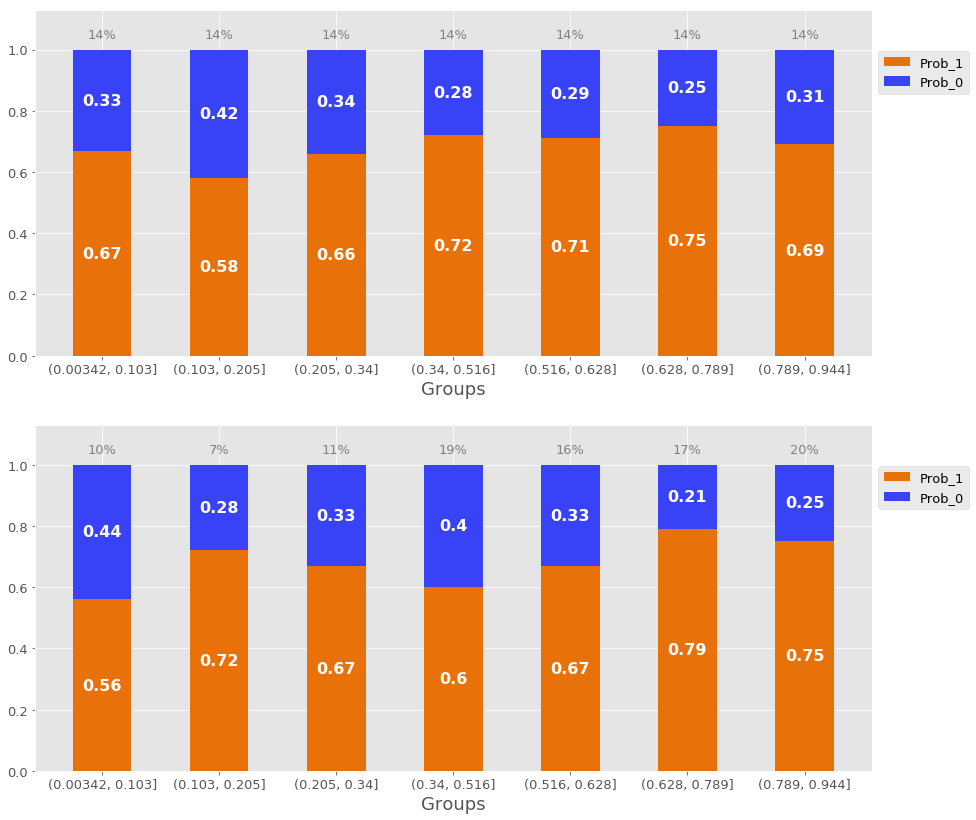

In [93]:
train_table, test_table, train_group, test_group = probability_groups(7, dados1.prob_treino, dados1.prob_resp, dados2.prob_teste, dados2.pred_teste)
plots_prob_groups (train_table, test_table)

In [91]:
print(train_table)
print('\n')
print(test_table)
print('\n')
print(train_group.head())
print('\n')
print(test_group.head())
print('\n')

                  N_0  N_1  total   P_1  P_total
prob_treino                                     
(0.00342, 0.179]   23   40     63  0.63     0.25
(0.179, 0.427]     23   39     62  0.63     0.25
(0.427, 0.666]     14   48     62  0.77     0.25
(0.666, 0.944]     19   44     63  0.70     0.25


            N_0  N_1  total   P_1  P_total
prob_teste                                
0            15   21     36  0.58     0.14
1            18   44     62  0.71     0.25
2            26   43     69  0.62     0.28
3            20   63     83  0.76     0.33


0    (0.00342, 0.179]
1    (0.00342, 0.179]
2    (0.00342, 0.179]
3    (0.00342, 0.179]
4    (0.00342, 0.179]
Name: prob_treino, dtype: category
Categories (4, interval[float64]): [(0.00342, 0.179] < (0.179, 0.427] < (0.427, 0.666] < (0.666, 0.944]]


0    2
1    2
2    1
3    3
4    0
Name: prob_teste, dtype: int64


